In [1]:
import pandas as pd
import numpy as np
import time
from pandas import Series
from matplotlib.pyplot import figure
import matplotlib.pylab as plt
from matplotlib import pyplot
%matplotlib inline
from datetime import datetime, timedelta
import re
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from statsmodels import tsa
from statsmodels.tsa.stattools import acf, pacf

In [2]:
df = pd.read_csv('Crime_Data.csv')
df.head

<bound method NDFrame.head of          Report Number Occurred Date  Occurred Time Reported Date  \
0       20080000465209    12/13/1908         2114.0    12/13/2008   
1       20100000202011    06/15/1964            0.0    06/15/2010   
2        2012000023437    01/01/1973            0.0    01/25/2012   
3       20130000327785    06/01/1974            0.0    09/09/2013   
4       20160000289384    01/01/1975            0.0    08/11/2016   
5        1975000079415    12/16/1975          900.0    12/16/1975   
6        1976000069169    01/01/1976            1.0    01/31/1976   
7       20170000474905    07/01/1976          800.0    12/27/2017   
8       20180000183590    01/01/1977            0.0    05/22/2018   
9       20090000300201    01/01/1978            1.0    08/25/2009   
10       1979000049118    01/28/1979         1600.0    02/09/1979   
11      20100000323749    07/04/1979            0.0    09/15/2010   
12      20100000177050    01/01/1980          952.0    05/28/2010   
13  

In [3]:
df=pd.DataFrame(df)
#s = df[['Occurred Date', 'Primary Offense Description']]
s = df[['Occurred Date', 'Crime Subcategory']]
s.dtypes
s.shape


(489631, 2)

In [4]:
#s.head()
#(s['Primary Offense Description'].value_counts()>3400)
s['Crime Subcategory'].value_counts()

CAR PROWL                              139827
THEFT-ALL OTHER                         50527
THEFT-SHOPLIFT                          45509
BURGLARY-RESIDENTIAL                    44498
MOTOR VEHICLE THEFT                     41040
BURGLARY-COMMERCIAL                     21661
THEFT-BUILDING                          19998
NARCOTIC                                16643
TRESPASS                                15268
AGGRAVATED ASSAULT                      14297
DUI                                     12010
ROBBERY-STREET                          11269
THEFT-BICYCLE                           10476
BURGLARY-RESIDENTIAL-SECURE PARKING      7896
FAMILY OFFENSE-NONVIOLENT                6479
AGGRAVATED ASSAULT-DV                    6437
SEX OFFENSE-OTHER                        5893
WEAPON                                   4657
ROBBERY-COMMERCIAL                       4193
PROSTITUTION                             3522
RAPE                                     1802
LIQUOR LAW VIOLATION              

In [5]:
s['date'] = pd.to_datetime(s['Occurred Date'],infer_datetime_format=True)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [6]:
s.head()

,Occurred Date,Crime Subcategory,date
0,12/13/1908,DUI,1908-12-13
1,06/15/1964,FAMILY OFFENSE-NONVIOLENT,1964-06-15
2,01/01/1973,SEX OFFENSE-OTHER,1973-01-01
3,06/01/1974,SEX OFFENSE-OTHER,1974-06-01
4,01/01/1975,SEX OFFENSE-OTHER,1975-01-01


In [7]:
s['date2']=s['date']
s.head()

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,Occurred Date,Crime Subcategory,date,date2
0,12/13/1908,DUI,1908-12-13,1908-12-13
1,06/15/1964,FAMILY OFFENSE-NONVIOLENT,1964-06-15,1964-06-15
2,01/01/1973,SEX OFFENSE-OTHER,1973-01-01,1973-01-01
3,06/01/1974,SEX OFFENSE-OTHER,1974-06-01,1974-06-01
4,01/01/1975,SEX OFFENSE-OTHER,1975-01-01,1975-01-01


In [8]:
person = s[s['Crime Subcategory'].isin(['HOMICIDE','RAPE','ROBBERY-STREET','ROBBERY-COMMERCIAL',
                               'ROBBERY-RESIDENTIAL','AGGRAVATED ASSAULT-DV','AGGRAVATED ASSAULT'])]
person.head()                                          

,Occurred Date,Crime Subcategory,date,date2
8,01/01/1977,RAPE,1977-01-01,1977-01-01
15,08/22/1981,HOMICIDE,1981-08-22,1981-08-22
19,01/01/1987,RAPE,1987-01-01,1987-01-01
24,01/01/1991,RAPE,1991-01-01,1991-01-01
28,02/09/1993,RAPE,1993-02-09,1993-02-09


In [9]:
mask = (person['date'] > '2007-12-31')
person = person.loc[mask]
person.head()
person['Crime Subcategory'].value_counts()

AGGRAVATED ASSAULT       14273
ROBBERY-STREET           11252
AGGRAVATED ASSAULT-DV     6423
ROBBERY-COMMERCIAL        4182
RAPE                      1741
ROBBERY-RESIDENTIAL       1003
HOMICIDE                   249
Name: Crime Subcategory, dtype: int64

In [10]:
personall = person.groupby(['date']).count()
personall.head()
personall.describe()

,Occurred Date,Crime Subcategory,date2
count,3893.000000,3893.000000,3893.000000
mean,10.049576,10.049576,10.049576
std,3.675893,3.675893,3.675893
min,1.000000,1.000000,1.000000
25%,7.000000,7.000000,7.000000
50%,10.000000,10.000000,10.000000
75%,12.000000,12.000000,12.000000
max,26.000000,26.000000,26.000000


In [11]:
property = s[s['Crime Subcategory'].isin(['ARSON','THEFT-ALL OTHER','THEFT-SHOPLIFT','THEFT-BUILDING',
                               'THEFT-BICYCLE','BURGLARY-RESIDENTIAL','BURGLARY-COMMERCIAL',
                                          'BURGLARY-COMMERCIAL-SECURE PARKING',
                                          'BURGLARY-RESIDENTIAL-SECURE PARKING',
                                          'MOTOR VEHICLE THEFT'])]
property.head()   

,Occurred Date,Crime Subcategory,date,date2
5,12/16/1975,BURGLARY-RESIDENTIAL,1975-12-16,1975-12-16
14,02/14/1981,BURGLARY-RESIDENTIAL,1981-02-14,1981-02-14
20,09/29/1988,MOTOR VEHICLE THEFT,1988-09-29,1988-09-29
27,01/01/1993,THEFT-ALL OTHER,1993-01-01,1993-01-01
32,06/08/1994,THEFT-ALL OTHER,1994-06-08,1994-06-08


In [12]:
mask = (property['date'] > '2007-12-31')
property = property.loc[mask]
property['Crime Subcategory'].value_counts()

THEFT-ALL OTHER                        50346
THEFT-SHOPLIFT                         45494
BURGLARY-RESIDENTIAL                   44430
MOTOR VEHICLE THEFT                    40994
BURGLARY-COMMERCIAL                    21624
THEFT-BUILDING                         19938
THEFT-BICYCLE                          10464
BURGLARY-RESIDENTIAL-SECURE PARKING     7894
BURGLARY-COMMERCIAL-SECURE PARKING      1065
ARSON                                   1027
Name: Crime Subcategory, dtype: int64

In [13]:
propertyall = property.groupby(['date']).count()
propertyall.head()
#propertyall.describe()

,Occurred Date,Crime Subcategory,date2
date,,,
2008-01-01,77,77,77
2008-01-02,41,41,41
2008-01-03,56,56,56
2008-01-04,57,57,57
2008-01-05,57,57,57


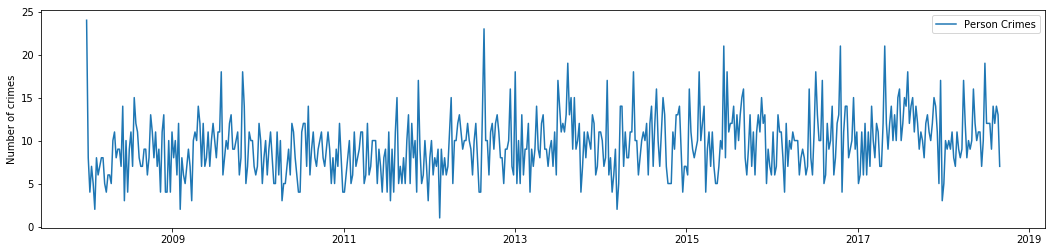

In [14]:
#fig, ax = plt.subplots(1, 1, figsize=(12, 14))
# b.plot(subplots=False, figsize=(15, 6)); plt.legend(loc='best')
# plt.xlabel('date')
x = personall.iloc[::7, :]
plt.figure(figsize=[18,4]) 

plt.plot(x['Crime Subcategory'], label = 'Person Crimes')
plt.ylabel('Number of crimes')

plt.legend(loc='best')

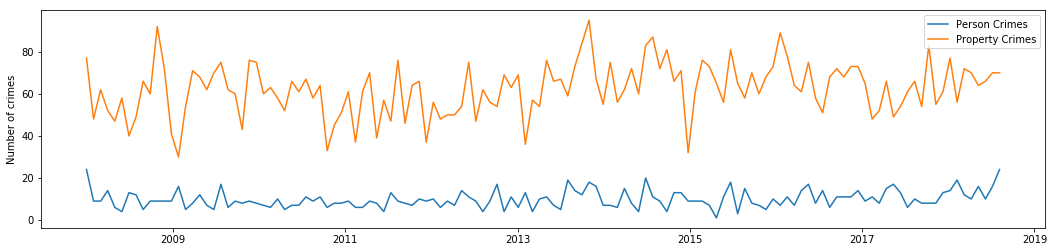

In [15]:
x = personall.iloc[::30, :]
plt.figure(figsize=[18,4]) 

plt.plot(x['Crime Subcategory'], label = 'Person Crimes')

y = propertyall.iloc[::30, :]

plt.plot(y['Crime Subcategory'], label = 'Property Crimes')
plt.ylabel('Number of crimes')

plt.legend(loc='best')

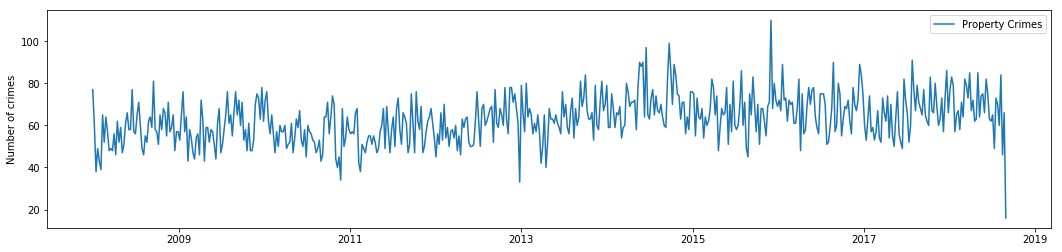

In [16]:
y = propertyall.iloc[::7, :]
plt.figure(figsize=[18,4]) 

plt.plot(y['Crime Subcategory'], label = 'Property Crimes')
plt.ylabel('Number of crimes')

plt.legend(loc='best')

In [17]:
mask = (person['date'] > '2016-12-31')
person2017 = person.loc[mask]
person2017['Crime Subcategory'].value_counts()

AGGRAVATED ASSAULT       3021
ROBBERY-STREET           1462
AGGRAVATED ASSAULT-DV    1212
ROBBERY-COMMERCIAL        993
RAPE                      408
ROBBERY-RESIDENTIAL       159
HOMICIDE                   48
Name: Crime Subcategory, dtype: int64

In [18]:
person7all = person2017.groupby(['date']).count()
person7all.head()

,Occurred Date,Crime Subcategory,date2
date,,,
2017-01-01,20,20,20
2017-01-02,9,9,9
2017-01-03,5,5,5
2017-01-04,8,8,8
2017-01-05,2,2,2


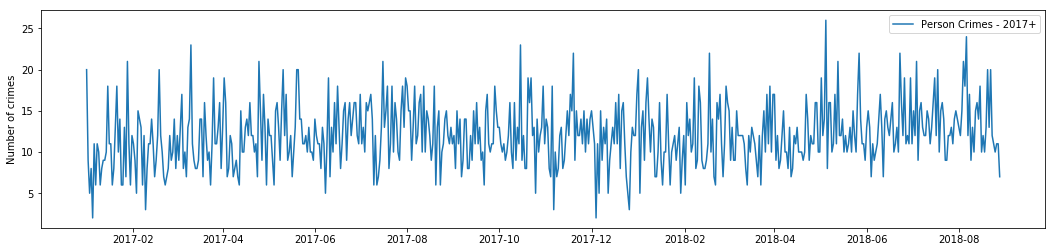

In [19]:
plt.figure(figsize=[18,4]) 

plt.plot(person7all['Crime Subcategory'], label = 'Person Crimes - 2017+')
plt.ylabel('Number of crimes')

plt.legend(loc='best')

In [20]:
mask = (property['date'] > '2016-12-31')
property2017 = property.loc[mask]
property2017['Crime Subcategory'].value_counts()

THEFT-ALL OTHER                        8307
THEFT-SHOPLIFT                         8099
MOTOR VEHICLE THEFT                    6164
BURGLARY-RESIDENTIAL                   5781
BURGLARY-COMMERCIAL                    4227
THEFT-BUILDING                         3270
BURGLARY-RESIDENTIAL-SECURE PARKING    2644
THEFT-BICYCLE                          1765
BURGLARY-COMMERCIAL-SECURE PARKING      288
ARSON                                   219
Name: Crime Subcategory, dtype: int64

In [21]:
property7all = property2017.groupby(['date']).count()
property7all.head()

,Occurred Date,Crime Subcategory,date2
date,,,
2017-01-01,69,69,69
2017-01-02,68,68,68
2017-01-03,60,60,60
2017-01-04,68,68,68
2017-01-05,65,65,65


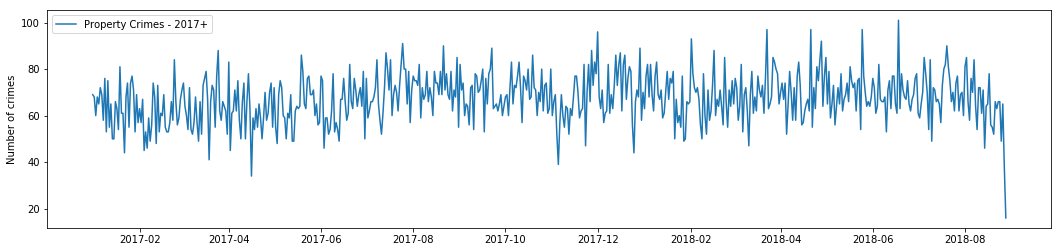

In [22]:
plt.figure(figsize=[18,4]) 

plt.plot(property7all['Crime Subcategory'], label = 'Property Crimes - 2017+')

plt.ylabel('Number of crimes')

plt.legend(loc='best')

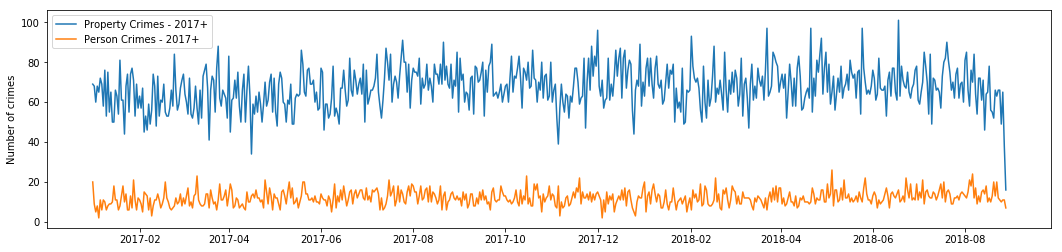

In [23]:
plt.figure(figsize=[18,4]) 
plt.plot(property7all['Crime Subcategory'], label = 'Property Crimes - 2017+')
plt.plot(person7all['Crime Subcategory'], label = 'Person Crimes - 2017+')
plt.ylabel('Number of crimes')

plt.legend(loc='best')

In [24]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=12).mean()
    rolstd = timeseries.rolling(window=12).std()

    #Plot rolling statistics:
    plt.figure(figsize=[18,4]) 
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

Person 2017+


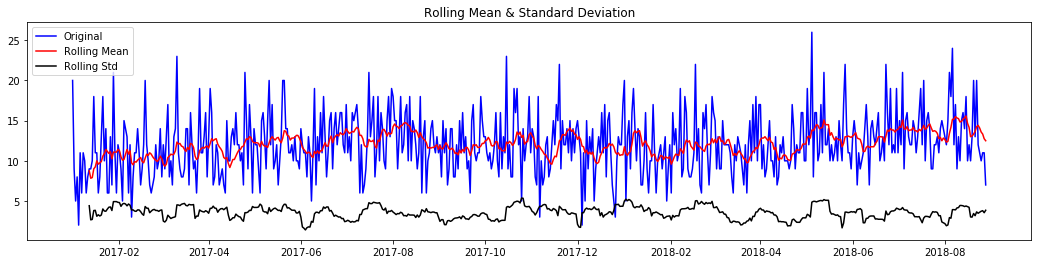

Results of Dickey-Fuller Test:
Test Statistic                -7.431772e+00
p-value                        6.333122e-11
#Lags Used                     6.000000e+00
Number of Observations Used    5.980000e+02
Critical Value (1%)           -3.441333e+00
Critical Value (5%)           -2.866385e+00
Critical Value (10%)          -2.569350e+00
dtype: float64
Property 2017+


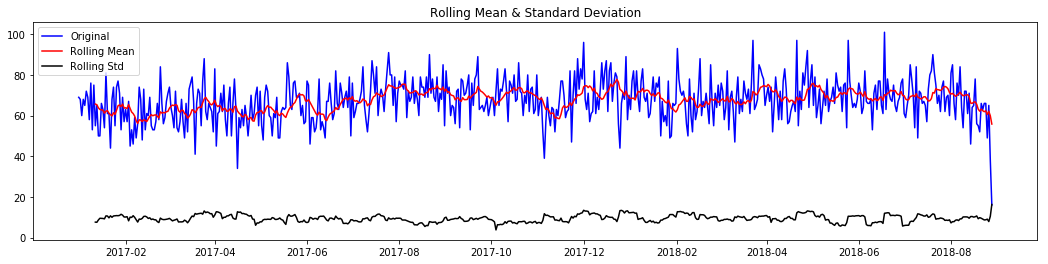

Results of Dickey-Fuller Test:
Test Statistic                  -3.228078
p-value                          0.018416
#Lags Used                      14.000000
Number of Observations Used    590.000000
Critical Value (1%)             -3.441482
Critical Value (5%)             -2.866451
Critical Value (10%)            -2.569386
dtype: float64
Person 2008+


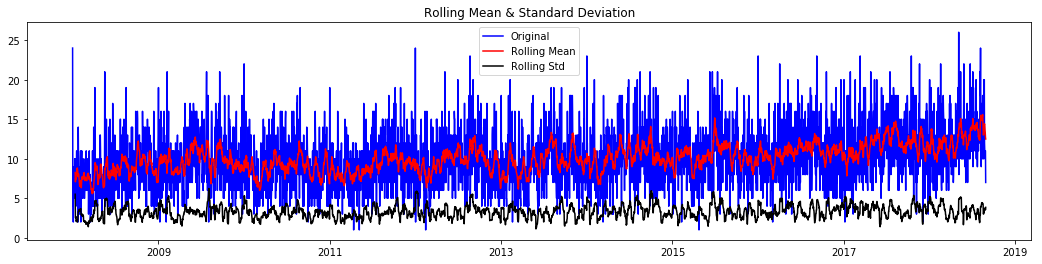

Results of Dickey-Fuller Test:
Test Statistic                   -5.471072
p-value                           0.000002
#Lags Used                       28.000000
Number of Observations Used    3864.000000
Critical Value (1%)              -3.432043
Critical Value (5%)              -2.862288
Critical Value (10%)             -2.567168
dtype: float64
Property 2008+


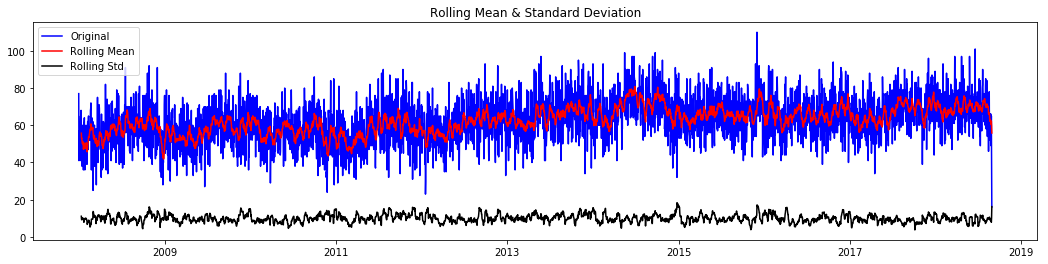

Results of Dickey-Fuller Test:
Test Statistic                   -4.394066
p-value                           0.000304
#Lags Used                       30.000000
Number of Observations Used    3862.000000
Critical Value (1%)              -3.432044
Critical Value (5%)              -2.862289
Critical Value (10%)             -2.567169
dtype: float64


In [25]:
print('Person 2017+')
test_stationarity(person7all['Crime Subcategory'])
print('Property 2017+')
test_stationarity(property7all['Crime Subcategory'])
print('Person 2008+')
test_stationarity(personall['Crime Subcategory'])
print('Property 2008+')
test_stationarity(propertyall['Crime Subcategory'])

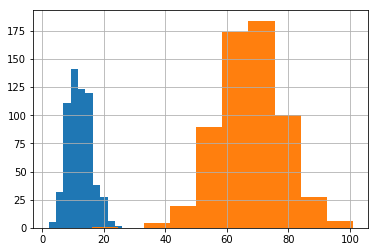

In [26]:
person7all['Crime Subcategory'].hist()
property7all['Crime Subcategory'].hist()


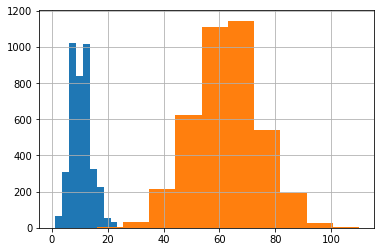

In [27]:
personall['Crime Subcategory'].hist()
propertyall['Crime Subcategory'].hist()

## Modeling

In [28]:
lag_acf = acf(person7all['Crime Subcategory'], nlags=20)
lag_pacf = pacf(person7all['Crime Subcategory'], nlags=20, method='ols')

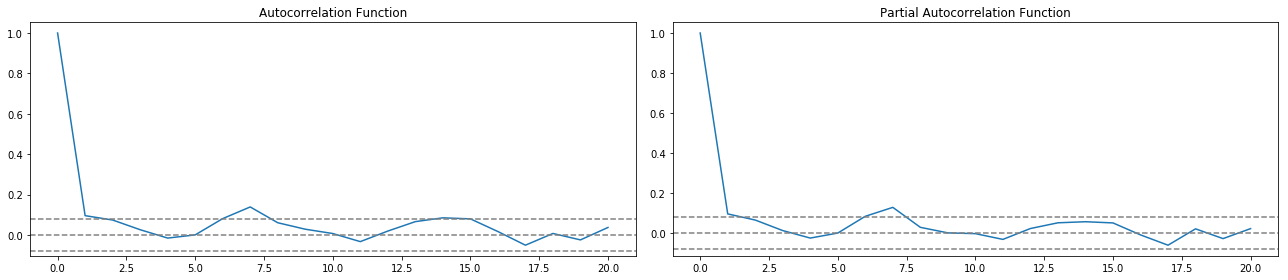

In [29]:
plt.figure(figsize=[18,4]) 
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(person7all['Crime Subcategory'])),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(person7all['Crime Subcategory'])),linestyle='--',color='gray')
plt.title('Autocorrelation Function')
#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(person7all['Crime Subcategory'])),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(person7all['Crime Subcategory'])),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Text(0.5,1,'RSS: 8557.4449')

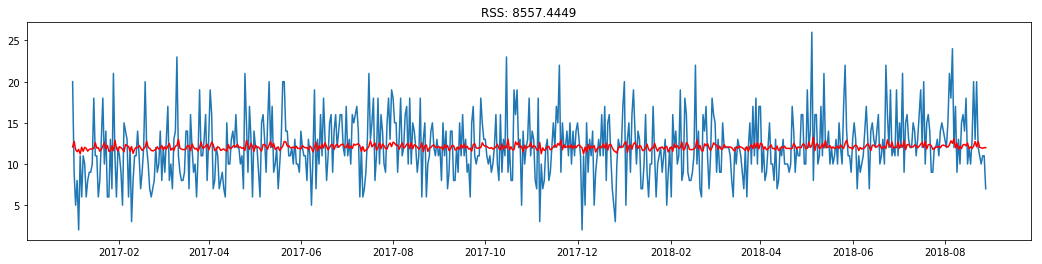

In [30]:
model = ARIMA(person7all['Crime Subcategory'], order=(0, 0, 1))  
results_MA = model.fit(disp=-1)  
plt.figure(figsize=[18,4]) 
plt.plot(person7all['Crime Subcategory'])
plt.plot(results_MA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_MA.fittedvalues-person7all['Crime Subcategory'])**2))


/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Text(0.5,1,'RSS: 8547.8330')

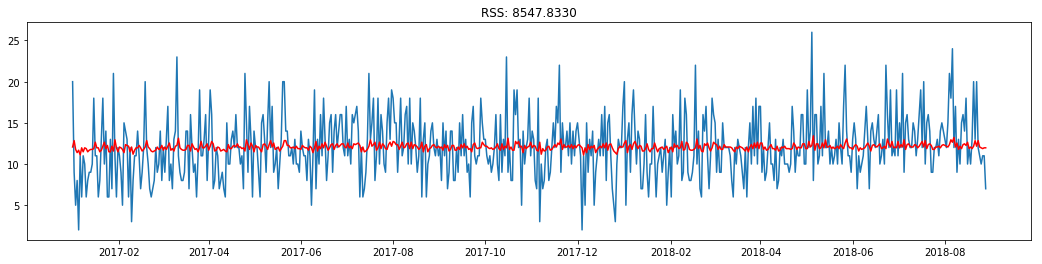

In [31]:
model = ARIMA(person7all['Crime Subcategory'], order=(1, 0, 0))  
results_MA = model.fit(disp=-1)  
plt.figure(figsize=[18,4]) 
plt.plot(person7all['Crime Subcategory'])
plt.plot(results_MA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_MA.fittedvalues-person7all['Crime Subcategory'])**2))

/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Text(0.5,1,'RSS: 8399.6557')

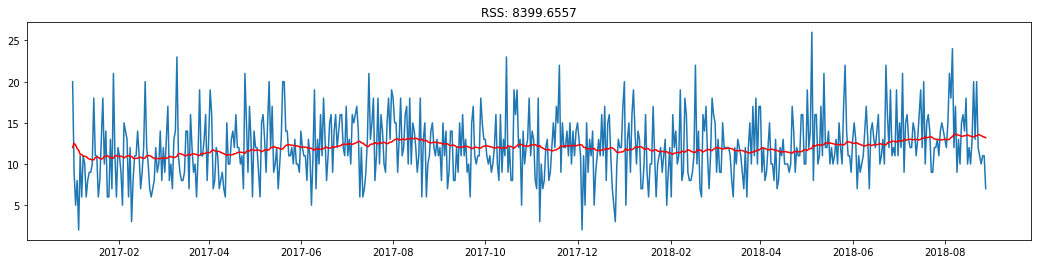

In [32]:
model = ARIMA(person7all['Crime Subcategory'], order=(1, 0, 1))  
results_ARIMA = model.fit(disp=-1)  
plt.figure(figsize=[18,4])
plt.plot(person7all['Crime Subcategory'])
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-person7all['Crime Subcategory'])**2))

In [33]:
from pyramid.arima import auto_arima
stepwise_model = auto_arima(person7all['Crime Subcategory'], start_p=1, start_q=1,
                           max_p=3, max_q=3, m=12,
                           start_P=0, seasonal=True,
                           d=1, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
print(stepwise_model.aic())

Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=3297.066, BIC=3318.984, Fit time=2.563 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 12); AIC=4014.869, BIC=4023.636, Fit time=0.055 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 12); AIC=3714.819, BIC=3732.353, Fit time=0.615 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=3295.299, BIC=3312.833, Fit time=1.952 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 1, 12); AIC=3296.696, BIC=3318.614, Fit time=2.057 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 0, 12); AIC=3658.365, BIC=3671.515, Fit time=0.633 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 2, 12); AIC=3296.365, BIC=3318.283, Fit time=4.204 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 2, 12); AIC=3299.239, BIC=3325.540, Fit time=6.111 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 1, 12); AIC=3656.524, BIC=3669.675, Fit time=0.733 seconds
Fit ARIMA: order=(0, 1, 2) s

In [34]:
# X = y['Crime Subcategory']
# size = int(len(X) * 0.66)
# train, test = X[0:size], X[size:len(X)]
# history = [x for x in train]
# predictions = list()
# for t in range(len(test)):
#     model = ARIMA(history, order=(5,1,0))
#     model_fit = model.fit(disp=0)
#     output = model_fit.forecast()
#     yhat = output[0]
#     predictions.append(yhat)
#     obs = test[t]
#     history.append(obs)
#     print('predicted=%f, expected=%f' % (yhat, obs))
# error = mean_squared_error(test, predictions)
# print('Test MSE: %.3f' % error)
# plot

plt.figure(figsize=[18,4]) 

plt.plot(test, label = 'Property Crimes', color='green')
plt.legend()
plt.figure(figsize=[18,4])
plt.plot(predictions, label = 'Predictions', color = 'red')
plt.legend()
#pyplot.plot(test)
#pyplot.plot(predictions, color='red')
#pyplot.show()

NameError: name 'test' is not defined

<Figure size 1296x288 with 0 Axes>